#### **Introduction to Vision Transformer (ViT)**

The [Vision Transformer](https://arxiv.org/abs/2010.11929) (ViT) represents an innovative breakthrough in how machines interpret images. Developed by Google Research, the ViT draws inspiration from the transformative impact of transformer models in Natural Language Processing (NLP). Traditionally, Convolutional Neural Networks (CNNs) dominated image analysis tasks. However, the introduction of ViT marked a paradigm shift, demonstrating that a model primarily designed for text could excel in visual domains as well. The ViT model has not only outperformed existing CNN-based methods across various image classification benchmarks but also shown remarkable scalability and generalization capabilities. Its success has led to its adoption in several leading-edge applications, including image segmentation in [Segment Anything](https://arxiv.org/abs/2304.02643) (SAM) and multimodal learning in [Contrastive Language-Image Pre-training](https://arxiv.org/pdf/2103.00020.pdf) (CLIP).

This notebook provides an introduction to the Vision Transformer (ViT) model, explaining its architecture and how it can be implemented using PyTorch for image classification tasks.

#### **CIFAR-10 Dataset**

The CIFAR-10 dataset will serve as our primary playground for experimenting with ViT.

Comprising 60,000 images, each 32x32 pixels and in full color, CIFAR-10 is categorized into 10 distinct classes, with each class containing 6,000 images. The dataset is divided into a training set of 50,000 images and a testing set of 10,000 images.

Use the following code snippet to download and prepare the data:

In [1]:
from torchvision import transforms, datasets

train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transforms.ToTensor(), # (1)
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transforms.ToTensor() # (2)
)

Files already downloaded and verified
Files already downloaded and verified


This script initializes the CIFAR-10 dataset for training and testing purposes using PyTorch's `datasets.CIFAR10` class for seamless data handling. 

**(1)** To initiate the training dataset, the script specifies the root directory for storing the data, sets the `train` parameter to `True`, and enables the download option. Additionally, it uses the `transforms.ToTensor()` method to convert the images into PyTorch tensors.

**(2)** To initialize the testing dataset, similar parameters are used except for the `train` parameter, which is set to `False`.

Let's visualize images from the CIFAR-10 dataset by defining the function `plot_class_examples`.

In [2]:
import matplotlib.pyplot as plt


def plot_class_examples(dataset, n_images=5):
    """
    Plot the first n_images for each class in the dataset.
    """
    classes = dataset.classes # (1)
    indices = {c: [] for c in range(len(classes))} # (2)

    for i, (_, label) in enumerate(dataset): # (3)
        if all(len(v) == n_images for v in indices.values()): # (4)
            break 
        if len(indices[label]) < n_images: # (5)
            indices[label].append(i) # (6)

    fig, axes = plt  \
        .subplots(n_images, len(classes), figsize=(16, 8), squeeze=False) # (7)

    for c, (class_idx, idx) in enumerate(indices.items()):  # (9)
        for j, index in enumerate(idx):  # (10)
            img = dataset[index][0].permute(1, 2, 0)  # (11)
            axes[j, c].imshow(img)
            axes[j, c].set(xticks=[], yticks=[])
            if j == 0:
                axes[j, c].set_title(classes[class_idx], size="large") 

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    ### plt.savefig("fig_08_Xn.pdf") 
    plt.show()

This function displays the first  `n_images` examples for each class from the dataset.

**(1)** The process starts by extracting the classes from the dataset and **(2)** initializing a dictionary to hold indices of images for each class. **(3-4)** Then, as it iterates over the dataset, the function checks whether enough images have been collected for each class. **(5-6)** If a class still needs more images, the current index is added to its list of indices. **(7)** Once the desired number of images for each class is reached, the function prepares a matplotlib figure with a grid of subplots. The subplots are arranged to have one row per class and one column per image. This ensures that the layout supports the visualization of all selected images. 

**(8-10)** For each class, the function iterates over its collected image indices, retrieves each image, permutes it for correct display formatting, and plots them in the corresponding subplot cell.

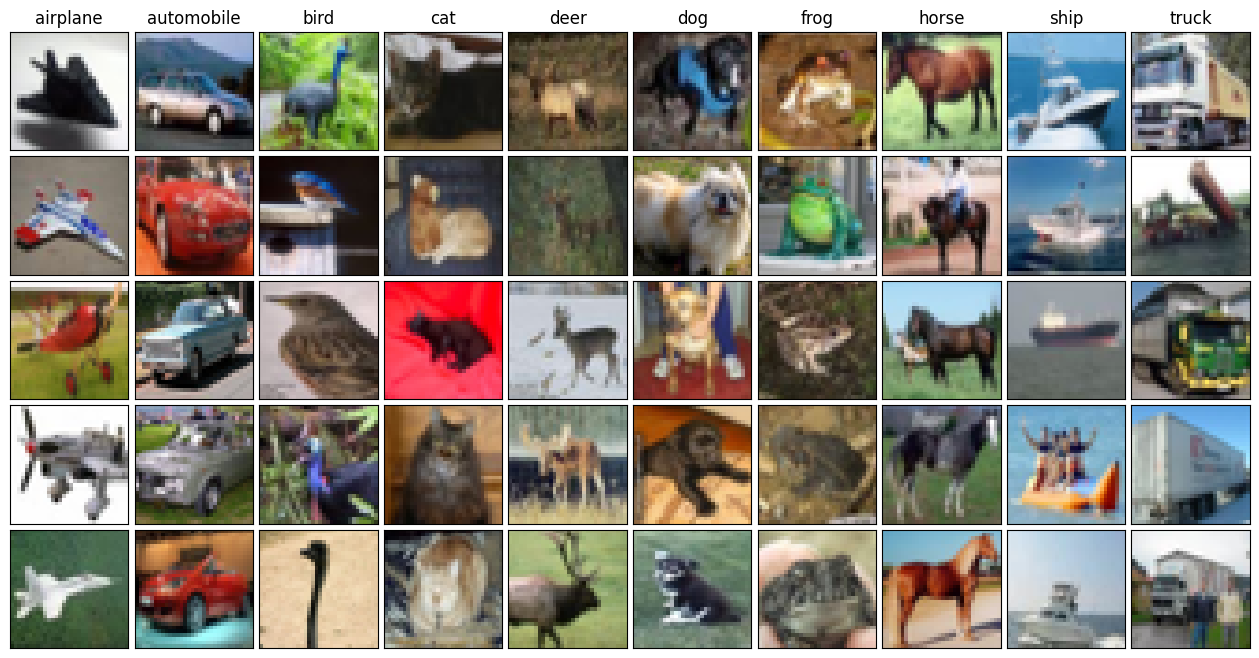

In [3]:
plot_class_examples(train_dataset, 5)

#### **Preparing the data**

Preparing the data involves more than just loading it; we also need to ensure that our model trains effectively and generalizes well to unseen data. To this end, the CIFAR-10 dataset, initially comprising only training and testing subsets, requires further partitioning to create a separate validation set.

For this purpose, we implement the `split_train_val` function, which splits the training set into training and validation subsets given a specified validation split ratio. This split allows us to independently evaluate the model's performance and make adjustments as needed without compromising the integrity of the test dataset.


In [4]:
import torch
from torch.utils.data import Subset

import copy

def split_train_val(dataset, val_split=0.2):
    """
    Splits a dataset into training and validation sets.
    """

    # Generate random indices
    indices = torch.randperm(len(dataset)).tolist() # (1)

    # Calculate split index
    split = int(len(dataset) * val_split) # (2)

    # Split indices
    train_indices, val_indices = indices[split:], indices[:split] # (3)

    # Create dataset subsets
    train_subset = Subset(dataset, train_indices) # (4)
    val_subset = Subset(copy.deepcopy(dataset), val_indices) # (5)

    return train_subset, val_subset

The `split_train_val` function takes a dataset and a validation split ratio as inputs, and returns the training and validation subsets. The function performs the following steps:

**(1)** It generates random indices for the dataset.

**(2)** It calculates the split index based on the validation split ratio.

**(3)** It splits the indices into training and validation indices.

**(4)** It creates the training subset using the `Subset` class, which allows us to create a subset of the dataset using the specified indices.

**(5)** It creates the validation subset using the same method as step 4. To ensure that the training and validation subsets are independent of each other, the function uses the `copy.deepcopy` function.

For this example, we will use a validation split ratio of 0.2, which means that 20% of the training data will be reserved for validation.

In [5]:
train_dataset, val_dataset = split_train_val(train_dataset, val_split=0.2)

To enhance the model's ability to generalize and prevent overfitting, we will apply various data augmentation techniques to the training dataset. 

In [6]:
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4), # (1)
        transforms.RandomHorizontalFlip(), # (2) 
        transforms.ToTensor(),
        transforms.Normalize(
            [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784] # (3)
        ),
    ]
)
train_dataset.dataset.transform = train_transform

These include **(1)** random cropping and padding, **(2)** horizontal flipping, and **(3)** normalization of the image tensors using the CIFAR-10 training set mean and standard deviation values for each channel.

For the validation dataset, however, we'll restrict the preprocessing to just conversion to tensors and normalization, avoiding augmentation to maintain the validity of the evaluation process.

In [7]:
val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]
        ),
    ]
)
val_dataset.dataset.transform = val_transform

#### **Defining data loaders**

Next, we will define data loaders that will feed the training, validation, and test data to the model during the training and evaluation processes.

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

#### **Building a Vision Transformer model**

Having prepared our dataset, we define the Vision Transformer (ViT) model. 

**Figure 1** illustrates the ViT architecture. It is built around four pivotal components that work together to process and classify images.

Firstly, **Image Patch Embeddings** play an essential role by slicing the input image into fixed-size, non-overlapping patches. These patches are linearly embedded, creating a series of flattened embeddings that serve as the input sequence for the transformer encoder (**Figure 1a**). To capture global information about the image, an additional learnable class token is integrated with these patch embeddings (**Figure 1b**). This class token, while not directly corresponding to any individual patch, symbolizes the collective image and its interactions with the embeddings, providing a holistic view for classification.

Secondly, the model incorporates **Positional Encodings** to permeate the patch embeddings with spatial context (**Figure 1b**). Unlike sin/cos encoding, these positional encodings are initially randomized and subsequently refined through the learning process, ensuring the model comprehends the layout and position of each patch within the image.

The **Transformer Encoder**, the third component, is the heart of the model (**Figure 1c**). It comprises several layers of transformer blocks that each feature a multi-head self-attention mechanism and a feedforward neural network. This structure allows the model to focus on different parts of the image simultaneously, facilitating a deeper understanding of the visual content.

The **Classification Head** or **Dense Top** is the last component of ViT (**Figure 1d**). It takes the class token output from the transformer encoder and feeds it through a feedforward neural network to predict the image's class label.


<p align="center">
  <img src="images/vit-image.png" width=600 height=auto>
  <br>
  <b>Figure 1. Vision Transformer (ViT) Architecture</b>
</p>

Let us now instantiate the ViT model

In [9]:
from deeplay import ViT 

model = ViT(
    in_channels=3, # (1)
    image_size=32, # (2)
    patch_size=4, # (3)
    hidden_features=[384,] * 7, # (4)
    out_features=10, # (5)
    num_heads=12,  # (6)
)

The Deeplay `ViT` class is responsible for managing the ViT (Vision Transformer) model architecture. The class constructor initializes the model components, including the patch embeddings, positional encodings, transformer encoder, and classification head. `ViT` accepts the following parameters:

**(1)** `in_channels`: This parameter defines the number of input channels in the image. For the CIFAR-10 dataset, the number of channels is 3 (RGB).

**(2)** `image_size`: This parameter defines the size of the input image, which is 32x32 for the CIFAR-10 dataset.

**(3)** `patch_size`: This parameter defines the size of the image patches. By dividing the image into smaller patches, the model can analyze the image in segments and learn local features before integrating them for global understanding. This parameter is set to 4, resulting in a total of 64 patches of size 4x4.

**(4)** `hidden_dim`: This parameter defines the dimension of the hidden layers in the transformer encoder. Seven transformer blocks (or layers) are defined in the model, each with a hidden size of 384 channels.

**(5)** `out_channels`: This parameter defines the number of classes in the dataset, which is 10 for CIFAR-10.

**(6)** `num_heads`: This parameter defines the number of attention heads in the multi-head self-attention mechanism. In this case, it is set to 12.


In [10]:
print(model)

ViT(
  (patch_embedder): Patchify(
    (layer): Layer[Conv2d](in_channels=3, out_channels=384, kernel_size=4, stride=4)
    (dropout): Layer[Dropout](p=0)
  )
  (positional_embedder): PositionalEmbedding(
    (dropout): Layer[Dropout](p=0)
  )
  (transformer_encoder): TransformerEncoderLayer(
    (blocks): LayerList(
      (0-6): 7 x SequentialBlock(
        (multihead): LayerDropoutSkipNormalization(
          (normalization): Layer[LayerNorm](normalized_shape=384)
          (layer): MultiheadSelfAttention(
            (projection): Layer[Identity]()
            (attention): Layer[MultiheadAttention](embed_dim=384, num_heads=12, batch_first=True)
          )
          (dropout): Layer[Dropout](p=0)
          (skip): Add()
        )
        (feed_forward): LayerDropoutSkipNormalization(
          (normalization): Layer[LayerNorm](normalized_shape=384)
          (layer): MultiLayerPerceptron(
            (blocks): LayerList(
              (0-1): 2 x LinearBlock(
                (layer):

#### **Training the model**

The following create a `Trainer` object to train the model.

We will use the Adam optimizer with a learning rate of `1e-3` and weight decay of `1e-5`, and `CrossEntropyLoss` as the loss function.

In [11]:
from deeplay import Classifier, Adam, Trainer

from lightning.pytorch.callbacks import ModelCheckpoint

classifier = Classifier(
    model=model,
    optimizer=Adam(
        lr=1e-3,
        weight_decay=5e-5,
        betas=(0.9, 0.999),
    ),
    num_classes=10,
).create()

checkpoint_callback = ModelCheckpoint(  # (2)
    monitor="valMulticlassAccuracy",
    mode="max",
    dirpath="checkpoint_classifier",
    filename="cifar10-{epoch:02d}-{valMulticlassAccuracy:.2f}",
    auto_insert_metric_name=False,
)

trainer = Trainer(max_epochs=100, callbacks=[checkpoint_callback])

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [12]:
trainer.fit(classifier, train_dataloader, val_dataloader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/Ch08_Attention/ec08_C_vit/checkpoint_classifier exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ CrossEntropyLoss │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ ViT              │  6.4 M │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 6.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.4 M                                                                                                
Total estimated model params size (MB): 25                                                                         
Modules in train mode: 174                                                                                         
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to 
speed up the dataloader worker initialization.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to
speed up the dataloader worker initialization.

Use the following code snippet to visualize the training and validation loss and accuracy.

(<Figure size 1500x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Step'>,
        <Axes: title={'center': 'Multiclassaccuracy'}, xlabel='Step'>],
       dtype=object))

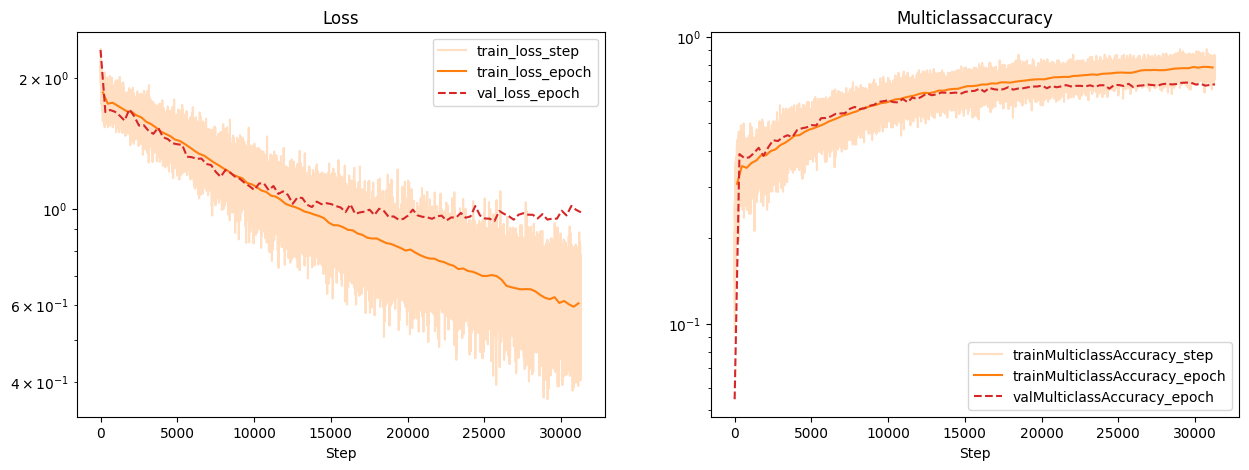

In [13]:
trainer.history.plot()

The ViT model achieves a validation accuracy of approximately 76% and reaches saturation at that point. While this is not a bad performance, it is still far from being comparable to the classification ability of Convolutional Neural Networks.

On the test set, the model achieves a similar accuracy:

In [14]:
import glob
import os

best_model_path = glob.glob(os.path.join("checkpoint_classifier", "*.ckpt"))
best_model_path = sorted(best_model_path, key=os.path.getmtime)[-1]

checkpoint = torch.load(best_model_path)
classifier.load_state_dict(checkpoint["state_dict"])

test_dataset.transform = val_transform
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

trainer.test(classifier, test_loader)

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.6827999949455261      │
│       test_loss_epoch        │      0.9502228498458862      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 0.9502228498458862,
  'testMulticlassAccuracy_epoch': 0.6827999949455261}]

However, the ViT model can be further fine-tuned to improve its performance.

#### **Improving the model**

Compared to CNNs, ViT models lack strong inductive biases. Inductive bias refers to the set of assumptions a model makes about the data it trains on to generalize from the training data to unseen data effectively. For instance, CNNs inherently assume spatial hierarchies in images, leveraging local patterns (e.g., edges and textures in early layers) and composing them into higher-order features (like objects) in deeper layers. This architectural  innatency towards capturing spatial locality and translation invariance directly supports learning from image data.

Due to the absence of these biases, ViT requires a substantial amount of data to learn effectively. It treats the image as a sequence of patches and learns to interpret these without the innate advantage of assuming spatial correlations, relying instead on the data to dictate these relationships. Consequently, ViT models need larger datasets to achieve their impressive performance, as they must learn from scratch what CNNs get for free through their architecture.

The CIFAR-10 dataset, containing only 60,000 images, is relatively small compared to the massive datasets where ViT models excel. Although 60,000 might seem substantial, it pales in comparison to the vast datasets like ImageNet with over 14 million images, which have been instrumental in training ViTs to their state-of-the-art performance.

[CutMix](https://arxiv.org/abs/1905.04899) is a technique designed to address this challenge, among others. It works by forcing the network to learn local relationships more efficiently, effectively injecting the network with sufficient pathways to learn spatial insights without relying on vast amounts of data.

#### **Implementing CutMix**

CutMix is a data augmentation strategy that seeks to enhance the model's ability to understand and integrate local features within images, thereby improving its generalization capabilities. Originating from the idea of [Mixup](https://arxiv.org/abs/1710.09412), where two images are blended together by averaging their pixels, CutMix takes this concept further by combining patches from two different images rather than mixing their entire content. This technique not only enriches the dataset but also introduces a more challenging and nuanced learning task for the model.

In a typical CutMix  augmentation, a patch from one image is cut and pasted onto another image, and the labels are mixed proportionally to the area of the patches. This process creates a new training example that is a composite of features and labels from two distinct images. For the model, the task then becomes to predict a mixed label, reflecting the composition of the input image. The primary advantage of this method is its ability to force the model to focus on less dominant features of the image, promoting a deeper and more robust learning of spatial relationships and feature representations.

The following class `CutMix` implements the CutMix augmentation.

In [15]:
import numpy as np


class CutMix(object):
    def __init__(self, size, beta):
        self.size = size
        self.beta = beta

    def __call__(self, batch):
        img, label = batch
        rand_img, rand_label = self._shuffle_minibatch(batch)
        lam = np.random.beta(self.beta, self.beta)

        # Clone images to ensure the original batch is not modified
        augmented_img = img.clone()

        r_x = np.random.uniform(0, self.size)
        r_y = np.random.uniform(0, self.size)
        r_w = self.size * np.sqrt(1 - lam)
        r_h = self.size * np.sqrt(1 - lam)

        x1 = np.clip(int(r_x - r_w // 2), a_min=0, a_max=self.size)
        x2 = np.clip(int(r_x + r_w // 2), a_min=0, a_max=self.size)
        y1 = np.clip(int(r_y - r_h // 2), a_min=0, a_max=self.size)
        y2 = np.clip(int(r_y + r_h // 2), a_min=0, a_max=self.size)

        # Replace parts of the cloned images with parts from the randomized images
        augmented_img[:, :, y1:y2, x1:x2] = rand_img[:, :, y1:y2, x1:x2]

        lam = 1 - ((x2 - x1) * (y2 - y1) / (self.size**2))
        
        return augmented_img, label, rand_label, lam

    def _shuffle_minibatch(self, batch):
        img, label = batch
        rand_idx = torch.randperm(img.size(0))
        rand_img = img[rand_idx]
        rand_label = label[rand_idx]
        return rand_img, rand_label

Let's visualize the CutMix augmentation by applying it to a random pair of images from the training dataset.

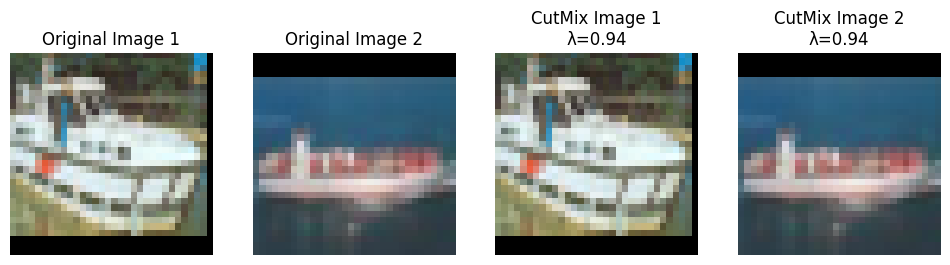

In [16]:
import random
from itertools import chain


def create_batch(samples):
    images, labels = zip(*samples)
    return torch.stack(images), torch.tensor(labels)


def normalize_image(image):
    mean = torch.tensor([0.49139968, 0.48215841, 0.44653091]).view(3, 1, 1)
    std = torch.tensor([0.24703223, 0.24348513, 0.26158784]).view(3, 1, 1)
    return image * std + mean


samples = random.choices(train_dataset, k=2)  # (1)
batch = create_batch(samples)  # (2)

augmented_img, *_, lam = CutMix(size=32, beta=1.0)(batch)  # (3)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))  # (4)
titles = ["Original Image 1", "Original Image 2", "CutMix Image 1", "CutMix Image 2"]

for i, (img, title) in enumerate(zip(chain(batch[0], augmented_img), titles)):
    axs[i].imshow(normalize_image(img).permute(1, 2, 0))
    axs[i].set_title(f"{title}\nλ={lam:.2f}" if "CutMix" in title else title)
    axs[i].axis("off")

plt.show()

This code snippet **(1)** selects two random images from the dataset `train_dataset`. Next, **(2)** the `create_batch` function is used to create a batch of images and labels from the selected images. **(3)** The `CutMix` class is then applied to the batch to generate the augmented images and labels. Finally, **(4)** the original and augmented images are displayed side by side for comparison.

*Please note that due to possibility of the shuffle operation resulting in the original order, there's a chance that the images might appear identical in certain instances. If this occurs, consider re-running the operation.*

#### **Training with CutMix**

To train the model with CutMix, we define the `CutMixClassifier` class, which extends the `Classifier` to incorporate the CutMix augmentation.

In [18]:
import torch.optim as optim
import warmup_scheduler


class CutMixClassifier(Classifier):
    def __init__(self, model, size=32, beta=1.0, **kwargs):
        super().__init__(model, **kwargs)

        self.cutmix = CutMix(size=size, beta=beta)

    def training_step(self, batch, batch_idx):

        augmented_img, labels, rand_labels, lam = self.cutmix(batch) # (1)

        output = self.model(augmented_img) # (2)
        loss = self.loss(output, labels) * lam + (1 - lam) * self.loss( # (3)
            output, rand_labels
        )

        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        self.log_metrics(
            "train",
            output,
            labels,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss

    def configure_optimizers(self):
        optimizer = super().configure_optimizers()

        base_scheduler = optim.lr_scheduler.CosineAnnealingLR( # (4)
            optimizer, T_max=200, eta_min=1e-5
        )
        scheduler = warmup_scheduler.GradualWarmupScheduler( # (5)
            optimizer, multiplier=1.0, total_epoch=5, after_scheduler=base_scheduler
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
            },
        }

During training,  **(1)** `CutMixClassifier` first applies CutMix augmentation to the input batch, creating augmented images with their corresponding labels and random labels alongside the mixing coefficient `lam`. **(2)** The model processes the augmented images, and **(3)** the loss is calculated using a combination of the original and random labels weighted by `lam` and `1-lam`, respectively, to reflect the proportion of each image in the augmented mix. 

To further enhance the performance of the model,  `CutMixClassifier` **(4)** sets up a learning rate schedule starting with a `CosineAnnealingLR` scheduler to adjust the learning rate following a cosine curve, and then **(5)** employs a warm-up phase using `GradualWarmupScheduler`,  which gradually increases the learning rate over the first five epochs to the initial learning rate before transitioning to the cosine annealing schedule. This approach optimizes the learning process, improving training stability and model performance.

Now we proceed to train the model using the `CutMixClassifier` class. 

The model is trained for 700 epochs to allow sufficient time for the model to learn from the augmented data and improve its performance.

In [19]:
model[..., "attention#-1"].log_output("attention_output") # (1)

classifier = CutMixClassifier(
    model=model,
    optimizer=Adam(lr=1e-3, weight_decay=5e-5, betas=(0.9, 0.999)),
    num_classes=10,
).create()

checkpoint_callback = ModelCheckpoint(
    monitor="valMulticlassAccuracy",
    mode="max",
    dirpath="checkpoint_cutmix_classifier",
    filename="cifar10-{epoch:02d}-{valMulticlassAccuracy:.2f}",
    auto_insert_metric_name=False,
)

trainer = Trainer(max_epochs=700, callbacks=[checkpoint_callback])

**(1)** the `log_output` method is used to log the output of the attention layer in the last transformer block. This will allow us to visualize the attention maps generated by the model during inference for interpretability purposes.

In [20]:
trainer.fit(classifier, train_dataloader, val_dataloader)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ CrossEntropyLoss │      0 │ train │
│ 1 │ train_metrics │ MetricCollection │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection │      0 │ train │
│ 4 │ model         │ ViT              │  6.4 M │ train │
│ 5 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 6.4 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.4 M                                                                                                
Total estimated model params size (MB): 25                                                                         
Modules in train mode: 174                                                                                         
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/torch/optim/
lr_scheduler.py:855: UserWarning: To get the last learning rate computed by the scheduler, please use 
`get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "

NameError: name 'exit' is not defined

Note that the model has achieved a validation accuracy of approximately 90%, which is a significant improvement over the previous accuracy of 76%.

In [21]:
best_model_path = glob.glob(os.path.join("checkpoint_cutmix_classifier", "*.ckpt"))
best_model_path = sorted(best_model_path, key=os.path.getmtime)[-1]

checkpoint = torch.load(best_model_path)
classifier.load_state_dict(checkpoint["state_dict"])

trainer.test(classifier, test_loader)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.8310999870300293      │
│       test_loss_epoch        │      0.5546495318412781      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 0.5546495318412781,
  'testMulticlassAccuracy_epoch': 0.8310999870300293}]

#### **Visualizing attention maps**

Let's visualize the model's performance by plotting test images, attention maps and predicted labels.

In [22]:
from skimage.transform import resize


samples = random.choices(test_dataset, k=4)
images, labels = create_batch(samples)

classifier.model.eval()
output = classifier(images)
preds = torch.argmax(output, dim=1)

attention_maps = classifier.logs["attention_output"][1][:, 0, 1:].reshape(4, 8, 8)


fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, (img, label, pred, attention_map) in enumerate(zip(images, labels, preds, attention_maps)):
    img = normalize_image(img).detach().permute(1, 2, 0)
    
    axs[0, i].imshow(img)
    axs[0, i].set_title(f"Label: {test_dataset.classes[label]}\nPred: {test_dataset.classes[pred]}")
    axs[0, i].axis("off")

    resized_attention_map = resize(attention_map.detach().numpy(), (32, 32), anti_aliasing=True)
    axs[1, i].imshow(img)
    axs[1, i].imshow(resized_attention_map, cmap="hot", alpha=0.5)
    axs[1, i].set_title("Attention Map")
    axs[1, i].axis("off")

plt.show()

KeyError: 'attention_output'

#### **Using a pre-trained ViT model**

The model achieved a 90% accuracy, which is comparable to the performance levels of CNNs on the CIFAR-10 dataset. However, as the original ViT paper states, this model achieves its best performance when trained on large-scale datasets like ImageNet, which contains millions of images. In such cases, the model can leverage its capacity to learn from vast amounts of data and generalize effectively, outperforming CNNs significantly.

To demonstrate this, we will use a pre-trained ViT model that has already learned rich representations from a diverse range of images in the ImageNet dataset. This model can perform well on a variety of tasks. 

The following loads the pre-trained ViT model and wrap it in a Torch Module that appends a classification head.

In [24]:
import torch.nn as nn

from transformers import ViTModel

class PretrainedViTModel(nn.Module):
    def __init__(self, output_channels, pretrained_model="google/vit-base-patch16-224-in21k"):
        super().__init__()

        self.backbone = ViTModel.from_pretrained(pretrained_model)

        hidden_features = self.backbone.config.hidden_size
        self.classifier = nn.Linear(hidden_features, output_channels)
   

    def forward(self, x):
        x = self.backbone(x).last_hidden_state[:, 0]
        return self.classifier(x)
    
pretrained_model = PretrainedViTModel(output_channels=10)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Images from ImageNet are typically larger than those in CIFAR-10, so we need to resize the images to 224x224 before feeding them to the model. We also normalize the images using the mean and standard deviation values of the ImageNet dataset.

In [25]:
import torchvision.transforms as transforms

from transformers import ViTImageProcessor


processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

train_transforms = [
    transforms.Resize((size, size)),
    transforms.RandomCrop(size, padding=4), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std),  
]

val_transforms = [
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std),
]

train_dataset.dataset.transform = transforms.Compose(train_transforms)
val_dataset.dataset.transform = transforms.Compose(val_transforms)
test_dataset.transform = transforms.Compose(val_transforms)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

We will redefine the data loaders to accommodate the resizing and normalization of the images.

In [26]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

and train the model using the `Classifier` class.

In [27]:
classifier = Classifier(
    model=pretrained_model,
    optimizer=Adam(lr=2e-5),
    num_classes=10,
).create()

trainer = Trainer(max_epochs=2)

trainer.fit(classifier, train_dataloader, val_dataloader)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ CrossEntropyLoss   │      0 │ train │
│ 1 │ train_metrics │ MetricCollection   │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection   │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection   │      0 │ train │
│ 4 │ model         │ PretrainedViTModel │ 86.4 M │ train │
│ 5 │ optimizer     │ Adam               │      0 │ train │
└───┴───────────────┴────────────────────┴────────┴───────┘

Trainable params: 86.4 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 86.4 M                                                                                               
Total estimated model params size (MB): 345                                                                        
Modules in train mode: 10                                                                                          
Modules in eval mode: 227

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

After only two epochs, the pre-trained ViT model achieves an accuracy of approximately 98% on the CIFAR-10 dataset, outperforming the performance of the model trained from scratch.

In [28]:
trainer.test(classifier, test_dataloader)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │      0.9789000153541565      │
│       test_loss_epoch        │     0.09001383185386658      │
└──────────────────────────────┴──────────────────────────────┘

[{'test_loss_epoch': 0.09001383185386658,
  'testMulticlassAccuracy_epoch': 0.9789000153541565}]